In [18]:
import re
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
df = pd.read_csv('./data/Bleached Softwood Kraft Pulp Futures Historical Data.csv')

In [20]:
def clean_data(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()
    cols = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

    for col in cols:
        if col == 'Vol.':
            df[col] = df[col].apply(lambda x: float(re.sub('K', '', x)) * 1000 if x != '-' else 0)
        elif col == 'Change %':
            df[col] = df[col].apply(lambda x: float(re.sub('%', '', x)) / 100)
        else:
            df[col] = df[col].apply(lambda x: float(re.sub(',', '', x)))
    
    return df


In [21]:
df = clean_data(df)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,09/18/2024,5564.0,5580.0,5600.0,5510.0,1150.0,0.0022
1,09/13/2024,5552.0,5532.0,5578.0,5526.0,310.0,0.0029
2,09/12/2024,5536.0,5566.0,5582.0,5510.0,180.0,-0.0018
3,09/11/2024,5546.0,5602.0,5624.0,5502.0,2180.0,-0.0142
4,09/10/2024,5626.0,5616.0,5670.0,5612.0,360.0,-0.0004


# Identify Stationary with Statistical Test: ADF, KPSS

## Augmented Dickey-Fuller(ADF) test

- Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. **Unit roots are a cause for non-stationarity**.

- **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

- **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

    - If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:
1.  the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%
    - **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    - **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
2.  the null hypothesis can be rejects if the test statistic is less than the critical value.

    - **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    - **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [22]:
def adftest(timeseries):
    result = adfuller(timeseries)
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    result_str = f"""
    Result of ADF test:
    ADF Statistic {adf_stat:0.3f}, 
    p-value: {p_val:0.3f}
    Critical Values  (1%): {crit_val_1:0.3f}, 
    Critical Values  (5%): {crit_val_5:0.3f}, 
    Critical Values  (10%): {crit_val_10:0.3f}
    """
    
    print(result_str)

In [23]:
adftest(df.Price)


    Result of ADF test:
    ADF Statistic -1.332, 
    p-value: 0.615
    Critical Values  (1%): -3.436, 
    Critical Values  (5%): -2.864, 
    Critical Values  (10%): -2.568
    


## KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

- KPSS is another test for checking the stationarity of a time series
- The null and alternate hypothesis for the KPSS test are opposite that of the ADF test

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

In [24]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        
    print (kpss_output)

In [25]:
kpss_test(df.Price)

Results of KPSS Test:
Test Statistic            1.27676
p-value                   0.01000
Lags Used                20.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


C:\Users\Sean\AppData\Local\Temp\ipykernel_20272\3989176356.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


## Conclusion

- The Price is not stationary, which means its statistic properties(mean, variance, covariance) vary with time.

## Cases

- Case 1: Both tests conclude that the series is not stationary -> series is not stationary
- Case 2: Both tests conclude that the series is stationary -> series is stationary
- Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
- Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

### Visualization

In [26]:
def visualize_adfuller_results(series, title, df):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    
    # Create a single plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df['Date'], y=series, color=linecolor)
    plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\n'
              f'Critical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}',
              fontsize=12)
    plt.ylabel(title, fontsize=10)
    plt.xlabel('Date', fontsize=10)
    plt.grid(True)
    plt.show()

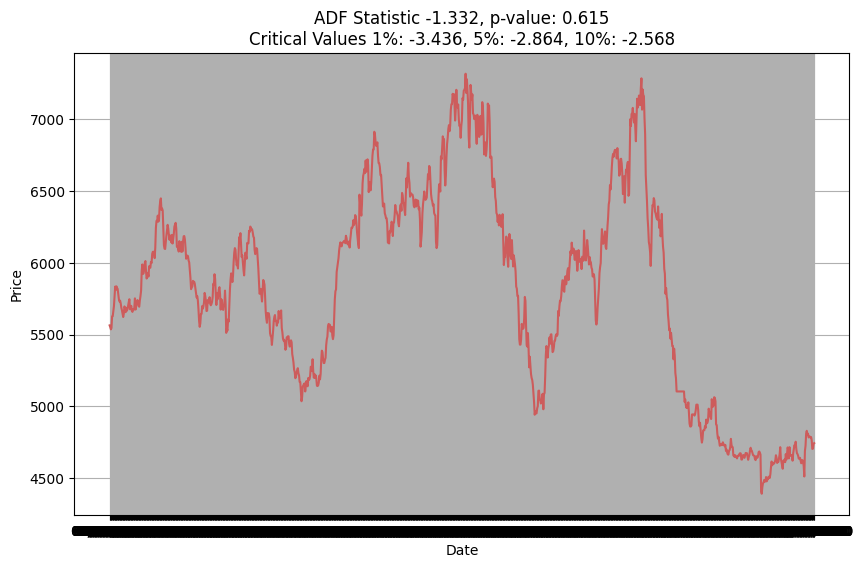

In [27]:
visualize_adfuller_results(df['Price'], 'Price', df)

### Example of a stationary data

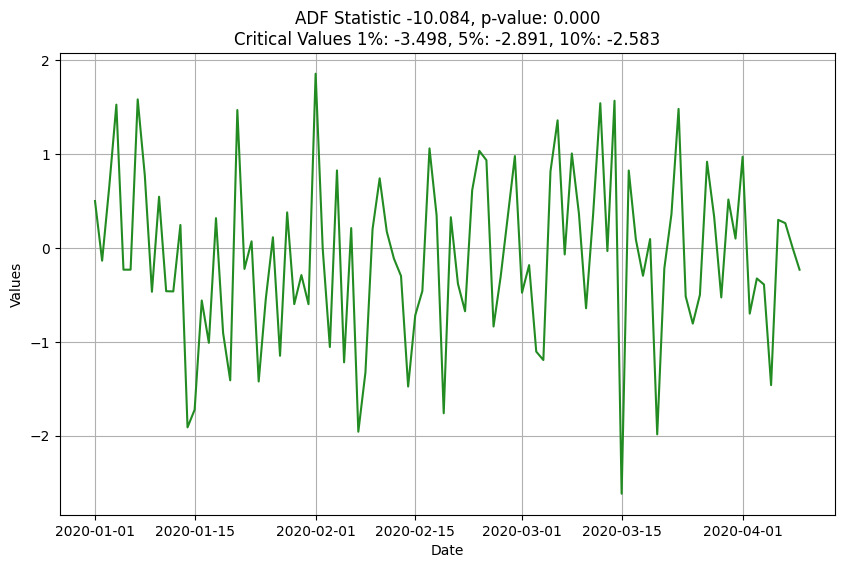

In [28]:
# Generate a stationary time series (random noise)
np.random.seed(42)  # For reproducibility
n = 100
stationary_series = np.random.normal(loc=0, scale=1, size=n)  # Mean = 0, Std = 1

# Create a DataFrame with a Date index
dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
df_stationary = pd.DataFrame({'Date': dates, 'Values': stationary_series})

visualize_adfuller_results(df_stationary['Values'], 'Values', df_stationary)

## Try to make the data become stationary

1. Differencing: 1 data point
2. Seasonal Differencing: 7 days
3. Transformation: power, square root, log